In [81]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import pymc3 as pm
import scipy as sp
import pyccl as ccl
import os
import utils
from make_data import MakeData
import getdist
from getdist import plots, MCSamples
%matplotlib inline

# Load data

In [82]:
names_planck  = ['H0_gp', 'omega_m', 's80', 'S80']
labels_planck = [r'H_0', r'\omega_{\rm{m}}', r'\sigma_{\rm{8}}',  r'\S_{\rm{8}}']

planck1 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_1.txt')
planck2 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_2.txt')
planck3 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_3.txt')
planck4 = np.loadtxt('/home/jaimerz/Master/PLANCK/Planck_TTTEEE_lowl_lowE/base_plikHM_TTTEEE_lowl_lowE_post_zre6p5_4.txt')

planck_tot = np.concatenate((planck1, planck2, planck3, planck4), axis=0)

planck_params = []
for item in planck_tot:
    planck_params.append([item[29], item[32], item[34], item[35]])
planck_params = np.array(planck_params)
planck_samples = MCSamples(samples=planck_params, names = names_planck, labels = labels_planck, label= r'$Planck$ 2018',
                    weights=np.transpose(planck_tot)[0],loglikes=np.transpose(planck_tot)[1])

Removed no burn in


In [83]:
z_max = 1110
res = 200
x_arr = np.linspace(0, np.log(1+z_max), res)
dx = np.mean(np.diff(x_arr))
z_arr = np.exp(x_arr)-1
a_arr = 1./(1+z_arr)

path = '/home/jaimerz/PhD/Growz/data/products'

data_class = MakeData(z_max, res , path)
Planck = data_class.Planck
z_planck = data_class.z_planck
c = data_class.c

DESI_data = data_class.get_DESI(new=True, mode=None)
WFIRST_data = data_class.get_WFIRST(new=True)
CC_data = data_class.get_CC(new=True)
DSS_data = data_class.get_DSS(new=True)
BOSS_data = data_class.get_BOSS(new=True)
eBOSS_data = data_class.get_eBOSS(new=True)
Wigglez_data = data_class.get_Wigglez(new=True)
DS17_data = data_class.get_DS17(new=True)
CMB_data = data_class.get_CMB(new=True)
FCMB_data = data_class.get_FCMB(new=True)

In [84]:
def get_m_s(rows):
    cols = np.transpose(rows)
    means = np.array([])
    sigmas = np.array([])
    for col in cols:
        mean = np.mean(col)
        sigma = np.std(col)
        means = np.append(means, mean)
        sigmas = np.append(sigmas, sigma)
    return means, sigmas

In [85]:
path = '/home/jaimerz/PhD/Growz/data/outputs/'
All = np.load(os.path.join(path,'fixed_eta/All_fixed_eta_100_100/samples.npz'))
All_CMB = np.load(os.path.join(path,'All_CMB_30000_30000/samples.npz'))
All_CMB_hp = np.load(os.path.join(path,'All_CMB_hp_10000_10000/samples.npz'))
All_CMB_geo_gro = np.load(os.path.join(path,'All_CMB_geo_gro_10000_10000/samples.npz'))
All_CMB_full = np.load(os.path.join(path,'All_CMB_full_100_100/samples.npz'))
All_CMB_Xi = np.load(os.path.join(path,'All_CMB_Xi_10000_10000/samples.npz'))
All_CMB_Xi_wm = np.load(os.path.join(path,'All_CMB_Xi_wm_10000_10000/samples.npz'))
All_CMB_Xi_full = np.load(os.path.join(path,'All_CMB_Xi_full_30000_30000/samples.npz'))
SDSS = np.load(os.path.join(path,'fulls/SDSS_1000_2500/samples.npz'))
SDSS_CMB = np.load(os.path.join(path,'SDSS_CMB_30000_30000/samples.npz'))
Add = np.load(os.path.join(path,'fulls/Add_1000_2500/samples.npz'))
Add_CMB = np.load(os.path.join(path,'Add_CMB_30000_30000/samples.npz'))
DESI = np.load(os.path.join(path,'fixed_eta/DESI_fixed_eta_100_100/samples.npz'))
DESI_CMB = np.load(os.path.join(path,'DESI_CMB_10000_10000/samples.npz'))
WFIRST_CMB = np.load(os.path.join(path,'WFIRST_CMB_10000_10000/samples.npz'))

In [6]:
def table_numbers(samples):
    for sample in samples:
        H0 = sample['H0_gp']
        H0_m = np.mean(H0)
        H0_s = np.std(H0)
        S80 = sample['S80']
        S80_m = np.mean(S80)
        S80_s = np.std(S80)
        s80 = sample['s80']
        s80_m = np.mean(s80)
        s80_s = np.std(s80)
        wm = sample['omega_m']
        wm_m = np.mean(wm)
        wm_s = np.std(wm)
        
        print('H0', H0_m, '+/-', H0_s)
        print('S80', S80_m, '+/-', S80_s)
        print('s80', s80_m, '+/-', s80_s)
        print('wm0', wm_m, '+/-', wm_s)
        print('-----')

In [79]:
table_numbers([All_CMB, All_CMB_hp, All_CMB_geo_gro, SDSS_CMB, Add_CMB, DESI_CMB])

H0 68.04582675339205 +/- 0.9430246489971721
S80 0.7942140576754035 +/- 0.02859226249531222
s80 0.9348473338673903 +/- 0.15342594051311603
wm0 0.10386661974360806 +/- 0.026737555411066653
-----
H0 68.69018694196372 +/- 0.8349429644402585
S80 0.7884398571886068 +/- 0.03006707009927973
s80 0.9393197552250313 +/- 0.15707705095205748
wm0 0.10242470626360309 +/- 0.029940814719875537
-----
H0 68.74115462551515 +/- 0.7902914942075867
S80 0.7769594719314071 +/- 0.028198532563074703
s80 0.9205525038401391 +/- 0.13049567978508342
wm0 0.11970148860684006 +/- 0.036647545104360295
-----
H0 67.4774953941611 +/- 0.9190377429794996
S80 0.836501722391238 +/- 0.05364547501445992
s80 0.9512528940773355 +/- 0.20341238814542661
wm0 0.12036299104560348 +/- 0.053855749385132344
-----
H0 67.44390708329618 +/- 0.5326083521741976
S80 0.7526940056678397 +/- 0.04982230117763747
s80 0.7304002345459498 +/- 0.22945335737171
wm0 0.17570649858916523 +/- 0.08374692088345725
-----
H0 67.39703521089791 +/- 0.2176838288079

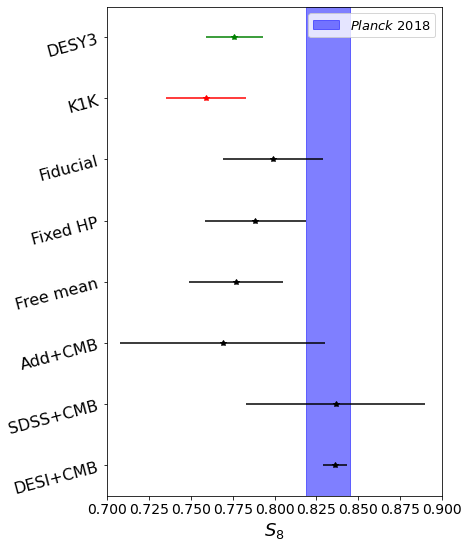

In [80]:
y = [0,2,4,6,8,10,12,14]
my_yticks = ['DESY3', 'K1K', 'Fiducial', 'Fixed HP', r'Free mean', r'Add+CMB', r'SDSS+CMB', r'DESI+CMB']

S8 = [0.776, 0.759, 
      0.7992495342600935, 0.7884398571886068,  0.7769594719314071,
      0.7690256125099253, 0.836501722391238 , 0.8359636703678847]
S8_err = [0.017, 0.024, 
          0.029819258836656884, 0.03006707009927973, 0.028198532563074703,
          0.0613422689121348, 0.05364547501445992, 0.007120492945776052]
    
plt.figure(figsize=(6,9))

plt.xlabel(r'$S_{\rm{8}}$', fontsize=18)

plt.errorbar( S8[0], y[0], xerr=np.transpose(S8_err[0]), fmt='g.')
plt.plot( S8[0], y[0], 'g*')

plt.errorbar( S8[1], y[1], xerr=np.transpose(S8_err[1]), fmt='r.')
plt.plot( S8[1], y[1], 'r*')

plt.errorbar( S8[2:], y[2:], xerr=np.transpose(S8_err[2:]), fmt='k.')
plt.plot( S8[2:], y[2:], 'k*')

plt.axvspan(0.832 - 0.013, 0.832 + 0.013, alpha = 0.5, color='b',  label= r'$Planck$ 2018')

plt.legend(loc = 1, prop={'size': 13})

plt.axis([0.7, 0.9,  y[-1]+1 ,-1,])

plt.yticks(y, my_yticks, fontsize=16)
plt.yticks(rotation=15)

plt.xticks(fontsize=14)

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/S8_comp.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/S8_comp.pdf')

In [9]:
def get_tensions(ref, names, values):
    for i, value in enumerate(values):
        p_mean = ref[0]
        p_sig = ref[1]**(2)
        means = value[0]
        sigs = value[1]**(2)
        tension = np.abs(p_mean-means)/np.sqrt(p_sig + sigs)
        print(names[i], 'vs Planck:', tension)
    return

In [10]:
get_tensions([0.832, 0.013], my_yticks, np.transpose([S8,S8_err]))

DESY3 vs Planck: 2.6167081556895844
K1K vs Planck: 2.674513064882686
Fiducial vs Planck: 1.0067833478851569
Fixed HP vs Planck: 1.3297917216049246
Free mean vs Planck: 1.7725914853784606
Add+CMB vs Planck: 1.0043016091151007
SDSS+CMB vs Planck: 0.7514524823861719
DESI+CMB vs Planck: 0.2674121268647565


In [11]:
All_CMB_Xi_full['l_Xi']

array([4.44814536, 3.52929527, 3.52929527, ..., 5.70181326, 5.80548421,
       5.45144553])

In [12]:
labels_dict = {'n': '\eta',
               'l': 'l',
               'n_H': '\eta_H',
               'l_H': 'l_H',
               'n_Xi': '\eta_{Xi}',
               'l_Xi': 'l_{Xi}',
               'H0': 'H_0',
               'H0_gp': 'H_0',
               'omega_m': '\omega_m',
               'omega_m_geo': '\omega_m^{mean}',
               'omega_b': '\omega_b',
               'Omega_m': '\Omega_m',
               'Omega_b': '\Omega_b',
               's80': '\sigma_8',
               'S80': 'S_8',
               'M': 'M'}
names_All = ['n', 'l', 'n_H', 'l_H', 'n_Xi', 'l_Xi',
             'H0', 'H0_gp',  'omega_m', 'omega_m_geo',
             'omega_b', 'Omega_m', 'Omega_b', 's80', 'S80', 'M']
#ranges = {'l':[0.001, 7], 'omega_b': [0.022, 0.023]}
ranges = {'l':[0.001, 7]}

# Triangle Plots

In [116]:
def make_samples(file, names, ranges, label):
    namess = []
    labels = []
    samples = []
    for name in names:
        if name in file.keys():
            namess.append(name) 
            labels.append(labels_dict[name]) 
            samples.append(file[name]) 
        
    return MCSamples(samples=samples, names=namess, labels=labels, label=label, ranges=ranges,
                    settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [117]:
WFIRST_CMB_samples = make_samples(WFIRST_CMB, ['n', 'l', 'H0_gp', 'omega_m',  'omega_b'], ranges, 'WFIRST+CMB')
DESI_samples = make_samples(DESI, ['l', 'H0_gp', 'omega_m',  's80', 'S80'], ranges, 'DESI')
DESI_CMB_samples = make_samples(DESI_CMB, ['n', 'l', 'H0_gp', 'omega_m',  'omega_b', 's80', 'S80'], ranges, 'DESI+CMB')
All_samples = make_samples(All, ['l', 'H0', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'All')
All_CMB_samples = make_samples(All_CMB, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'], ranges, 'All+CMB')
All_CMB_hp_samples = make_samples(All_CMB_hp, ['H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'All+CMB_hp')
All_CMB_geo_gro_samples = make_samples(All_CMB_geo_gro, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 'omega_m_geo', 's80', 'S80'],
                                           ranges, 'All+CMB_geo_gro')
All_CMB_wmean_samples = MCSamples(samples=[All_CMB_geo_gro['l'], All_CMB_geo_gro['omega_m_geo']], names=['l', 'omega_m'],
                                  labels=['l','\omega_m'],label='All+CMB_geo', ranges=ranges)
All_CMB_full_samples = make_samples(All_CMB_full, ['omega_b', 'omega_m', 's80'],
                                      ranges, 'All+CMB_full')
All_CMB_Xi_samples = make_samples(All_CMB_Xi, ['n', 'l', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'All+CMB_Xi')
All_CMB_Xi_full_samples = make_samples(All_CMB_Xi_full, ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'H0_gp', 'omega_b', 'omega_m', 's80', 'S80'],
                                      ranges, 'All+CMB_Xi_full')
SDSS_samples = make_samples(SDSS, ['n', 'l', 'H0_gp', 'Omega_m', 'Omega_b', 's80', 'S80'], ranges, 'SDSS')
SDSS_CMB_samples = make_samples(SDSS_CMB, ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'SDSS+CMB')
Add_samples = make_samples(Add, ['n', 'l', 'H0_gp', 'Omega_m', 's80', 'S80'], ranges, 'Add')
Add_CMB_samples = make_samples(Add_CMB, ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'], 
                                      ranges, 'Add+CMB')

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


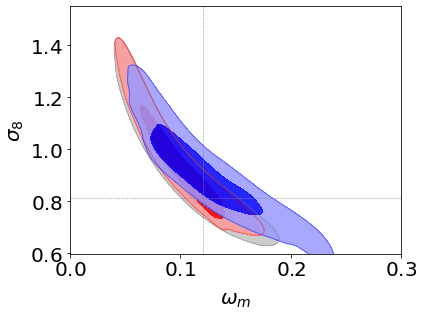

In [118]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([All_CMB_hp_samples,  All_CMB_samples, All_CMB_geo_gro_samples],
          'omega_m', 's80', filled=True,
          colors = ['grey', 'red', 'blue'],
          lims=[0, 0.3, 0.6, 1.55])
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_test.pdf')

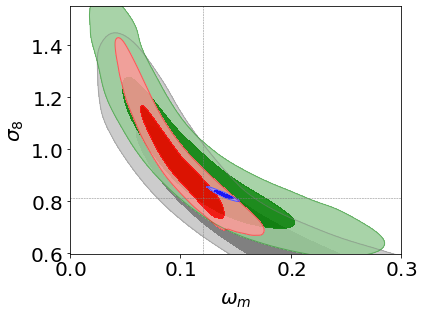

In [119]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([Add_CMB_samples, SDSS_CMB_samples, All_CMB_samples, DESI_CMB_samples],
          'omega_m', 's80', filled=True, 
           colors = ['grey','green', 'red', 'blue'],
           lims=[0, 0.3, 0.6, 1.55], 
           markers={'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                    's80': data_class.cosmo.sigma8()})
g.add_x_marker(0.1202)
g.add_y_marker(0.8120)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/banana_data.pdf')

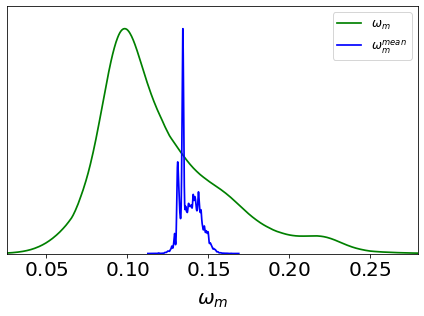

In [120]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_1d([All_CMB_geo_gro_samples, All_CMB_wmean_samples],'omega_m', 
          colors=['green', 'blue'])
g.add_legend([r'$\omega_m$', r'$\omega_m^{mean}$'])
             
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/geovsgro_1D.pdf')

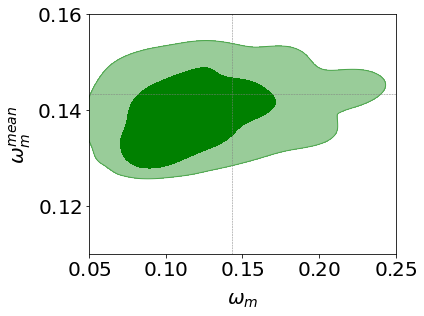

In [121]:
g = plots.get_single_plotter()
g.settings.axes_fontsize=20
g.settings.axes_labelsize = 20
g.plot_2d([All_CMB_geo_gro_samples],
          'omega_m', 'omega_m_geo', filled=True, 
           colors = ['green'],
           lims=[0.05, 0.25, 0.11, 0.16], 
           markers={'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                    's80': data_class.cosmo.sigma8()})
g.add_x_marker(0.1432)
g.add_y_marker(0.1432)

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/geovsgro_2D.pdf')

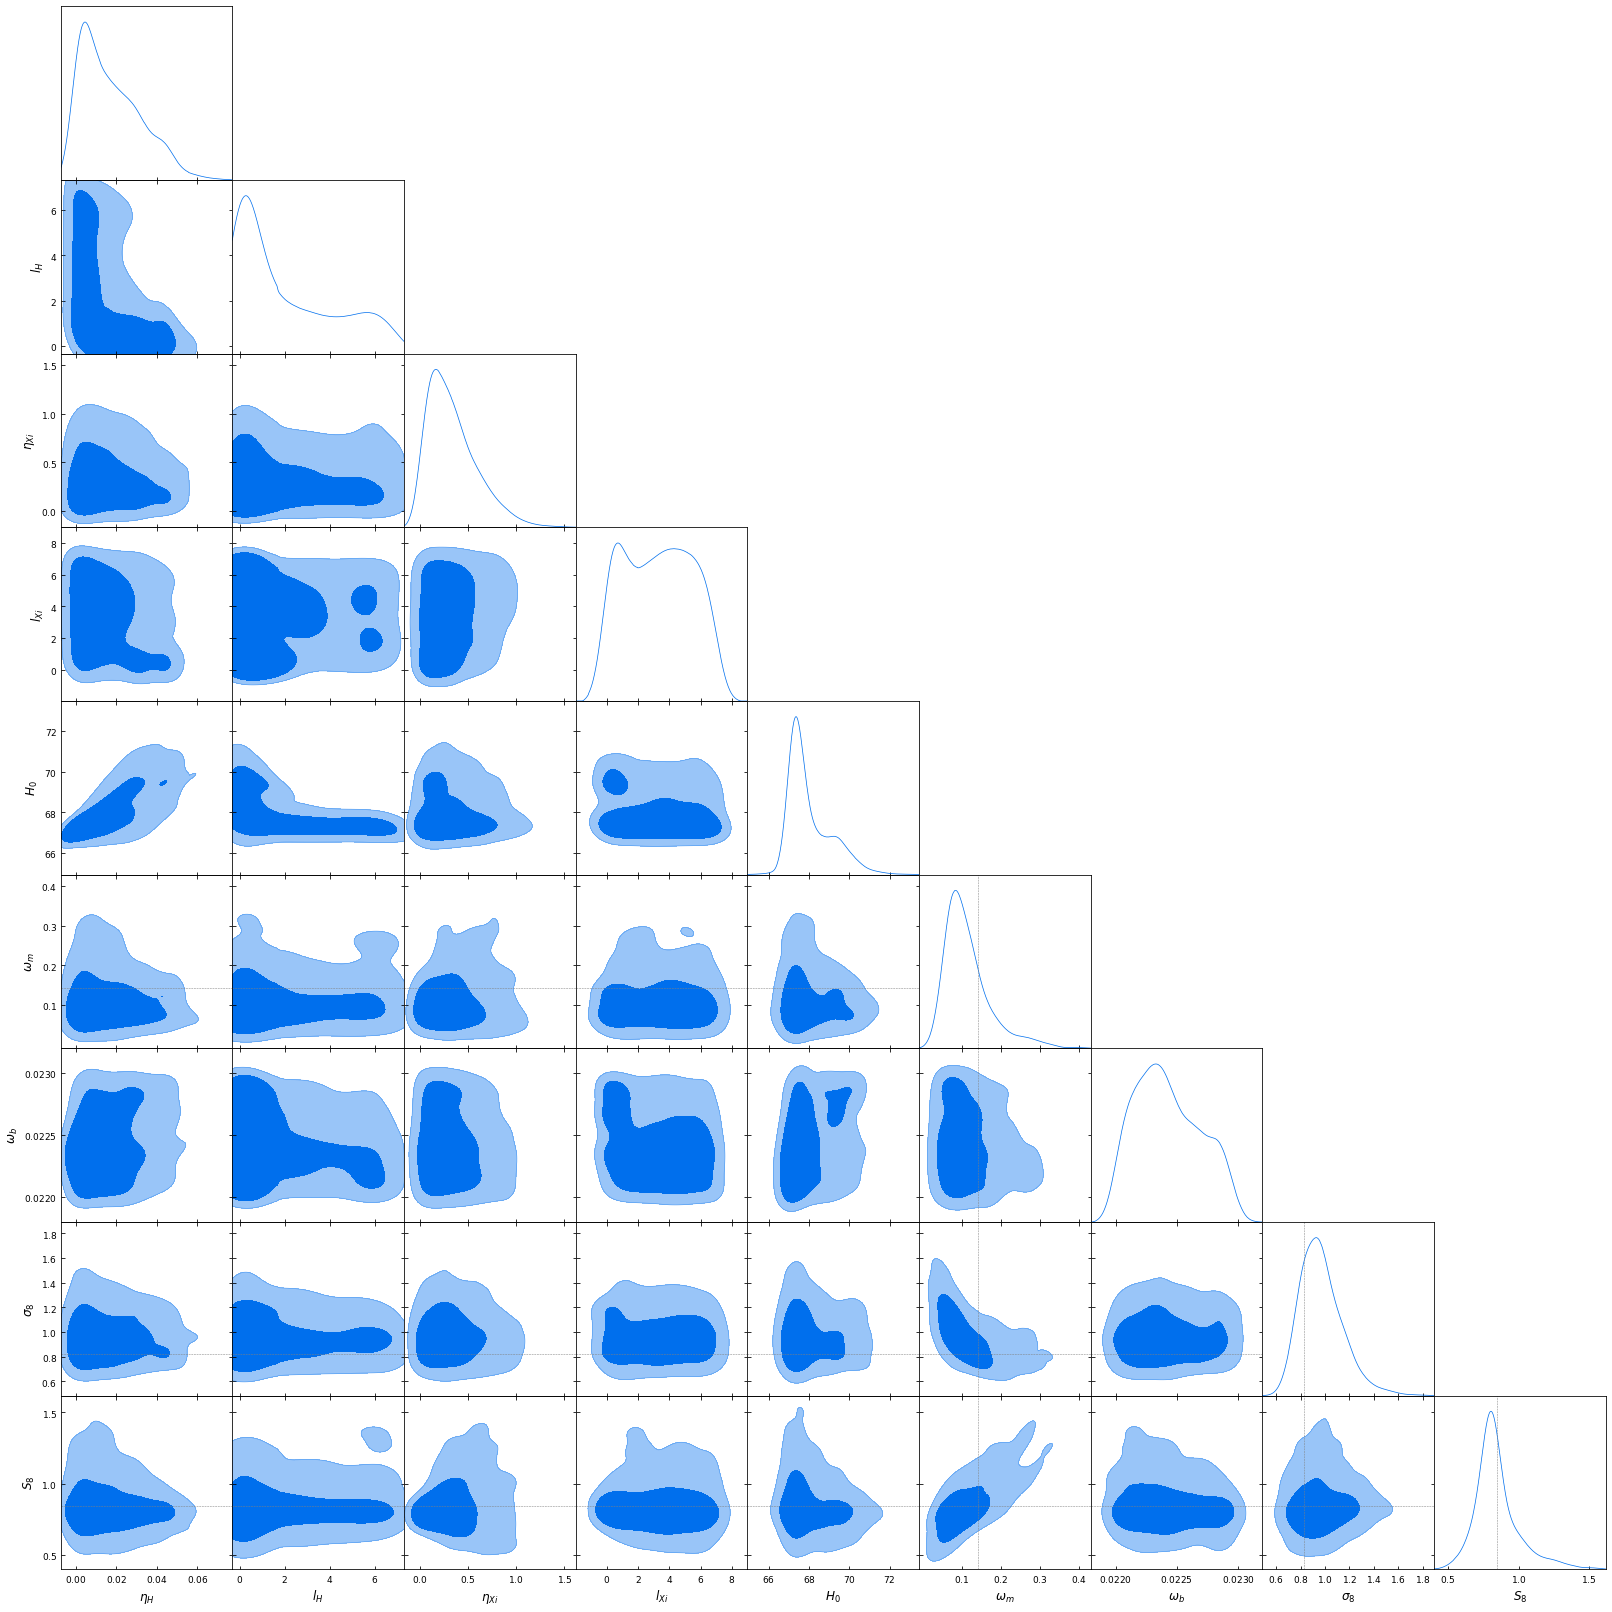

In [122]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([All_CMB_Xi_full_samples],
                ['n_H', 'l_H', 'n_Xi', 'l_Xi', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

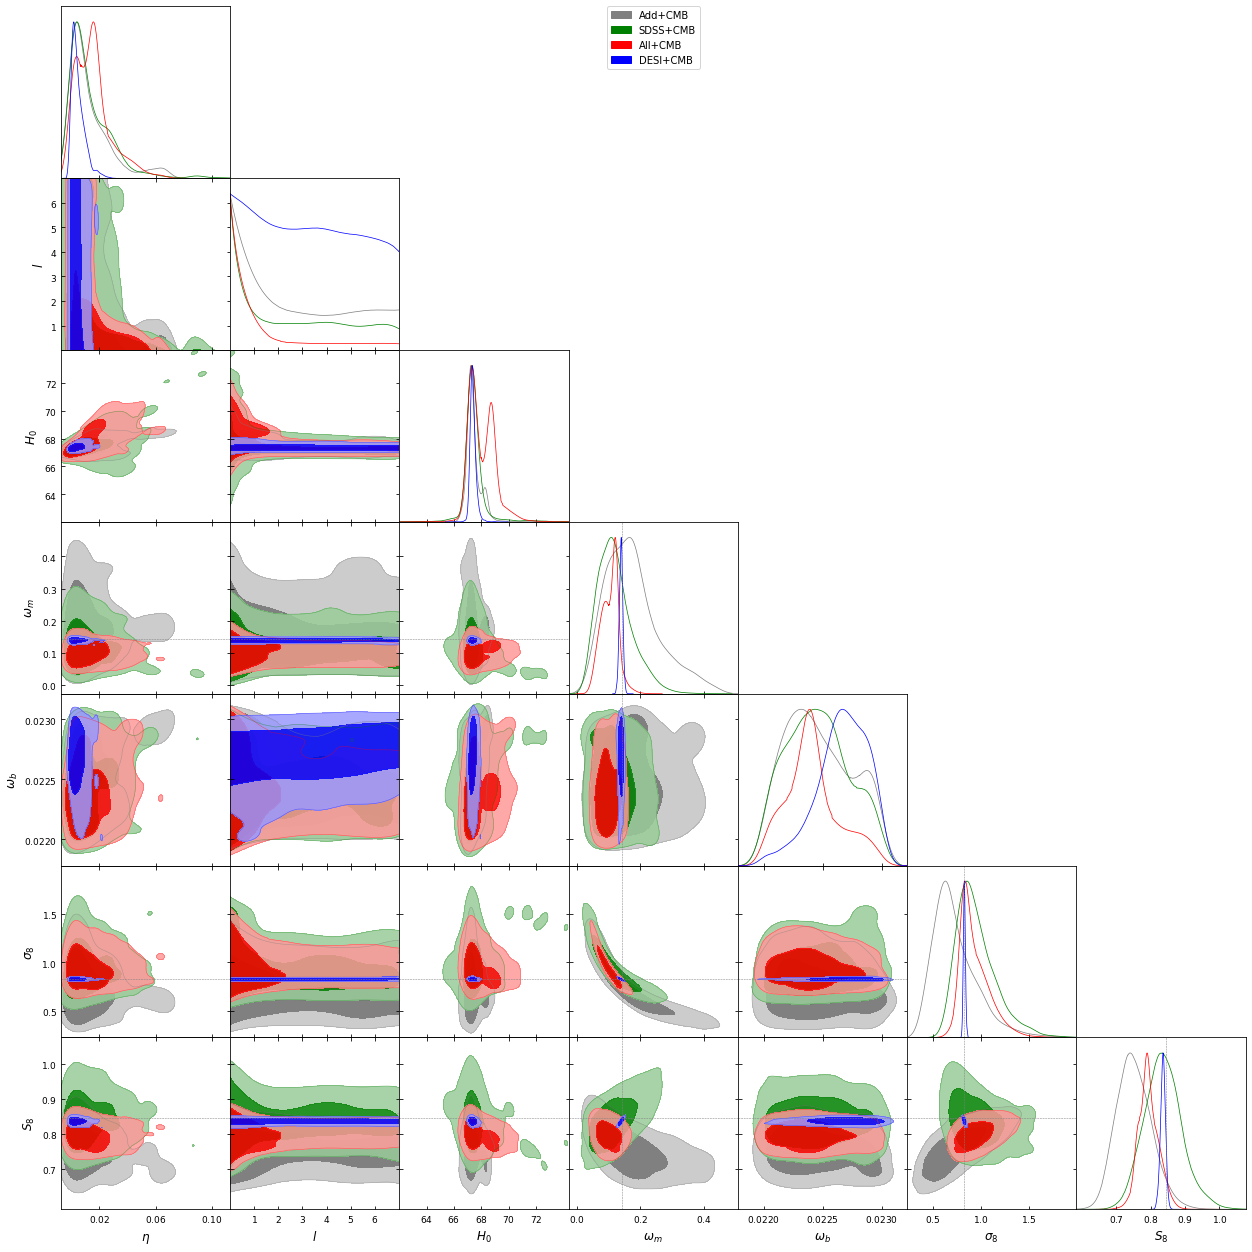

In [123]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([Add_CMB_samples,  SDSS_CMB_samples, All_CMB_samples, DESI_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                colors = ['grey', 'green', 'red', 'blue'],
                contour_colors = ['grey', 'green', 'red', 'blue'],
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
              
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_data.pdf')

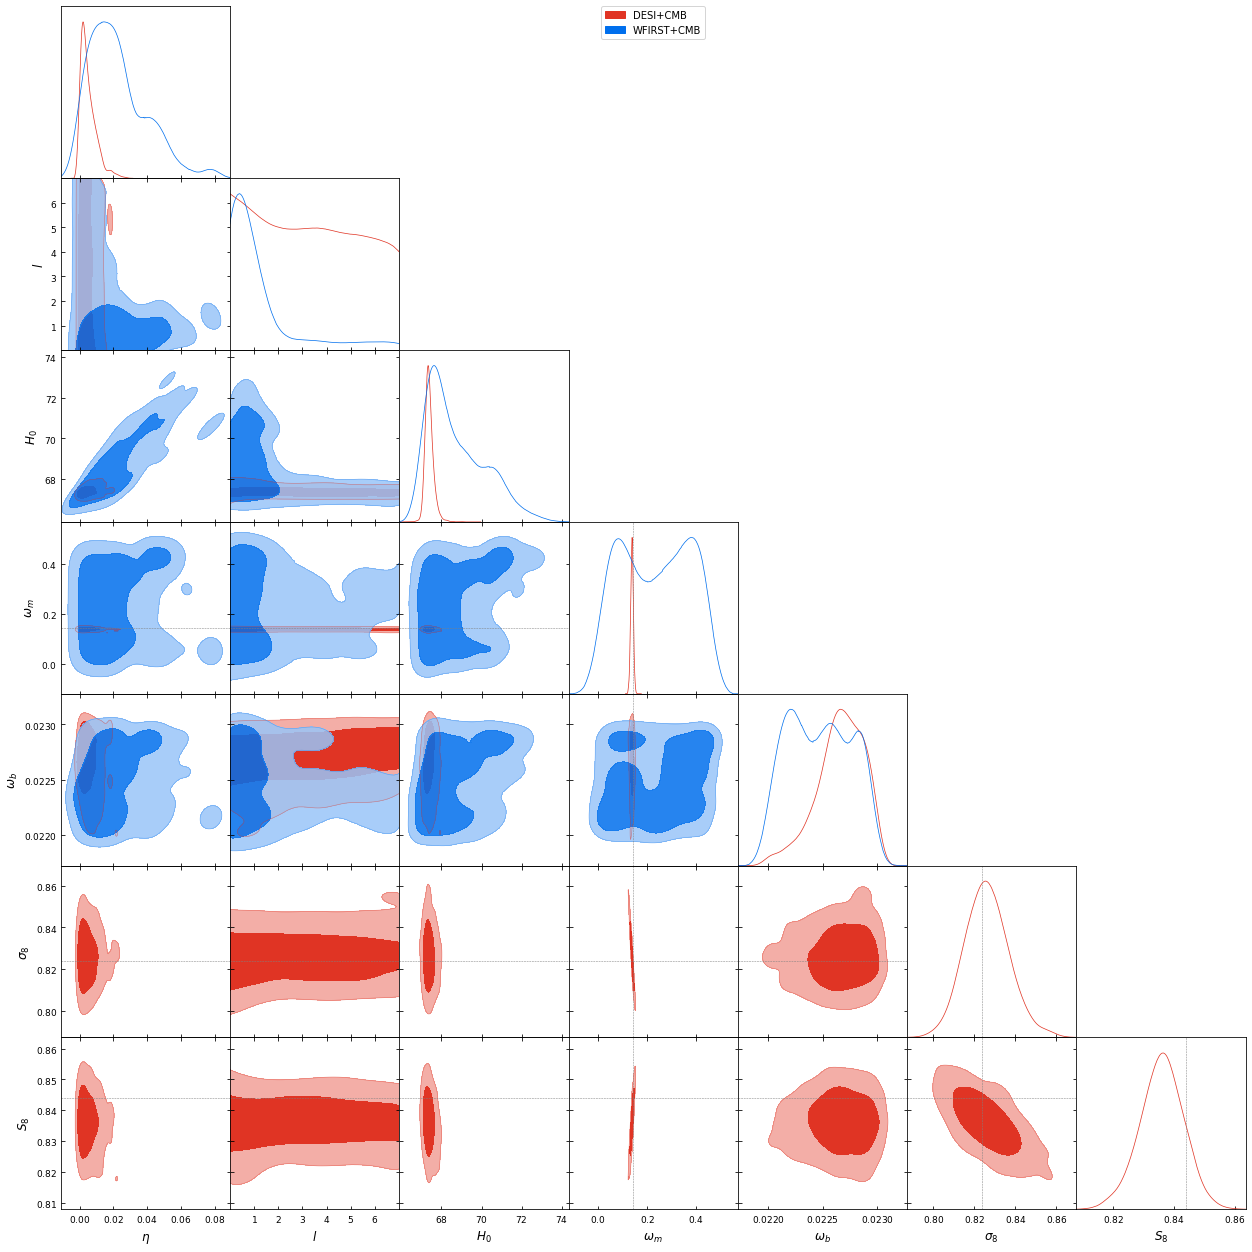

In [124]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([DESI_CMB_samples, WFIRST_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                filled=True,
                markers={'H0':100*data_class.cosmo.h(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})
                
g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_forecast.pdf')

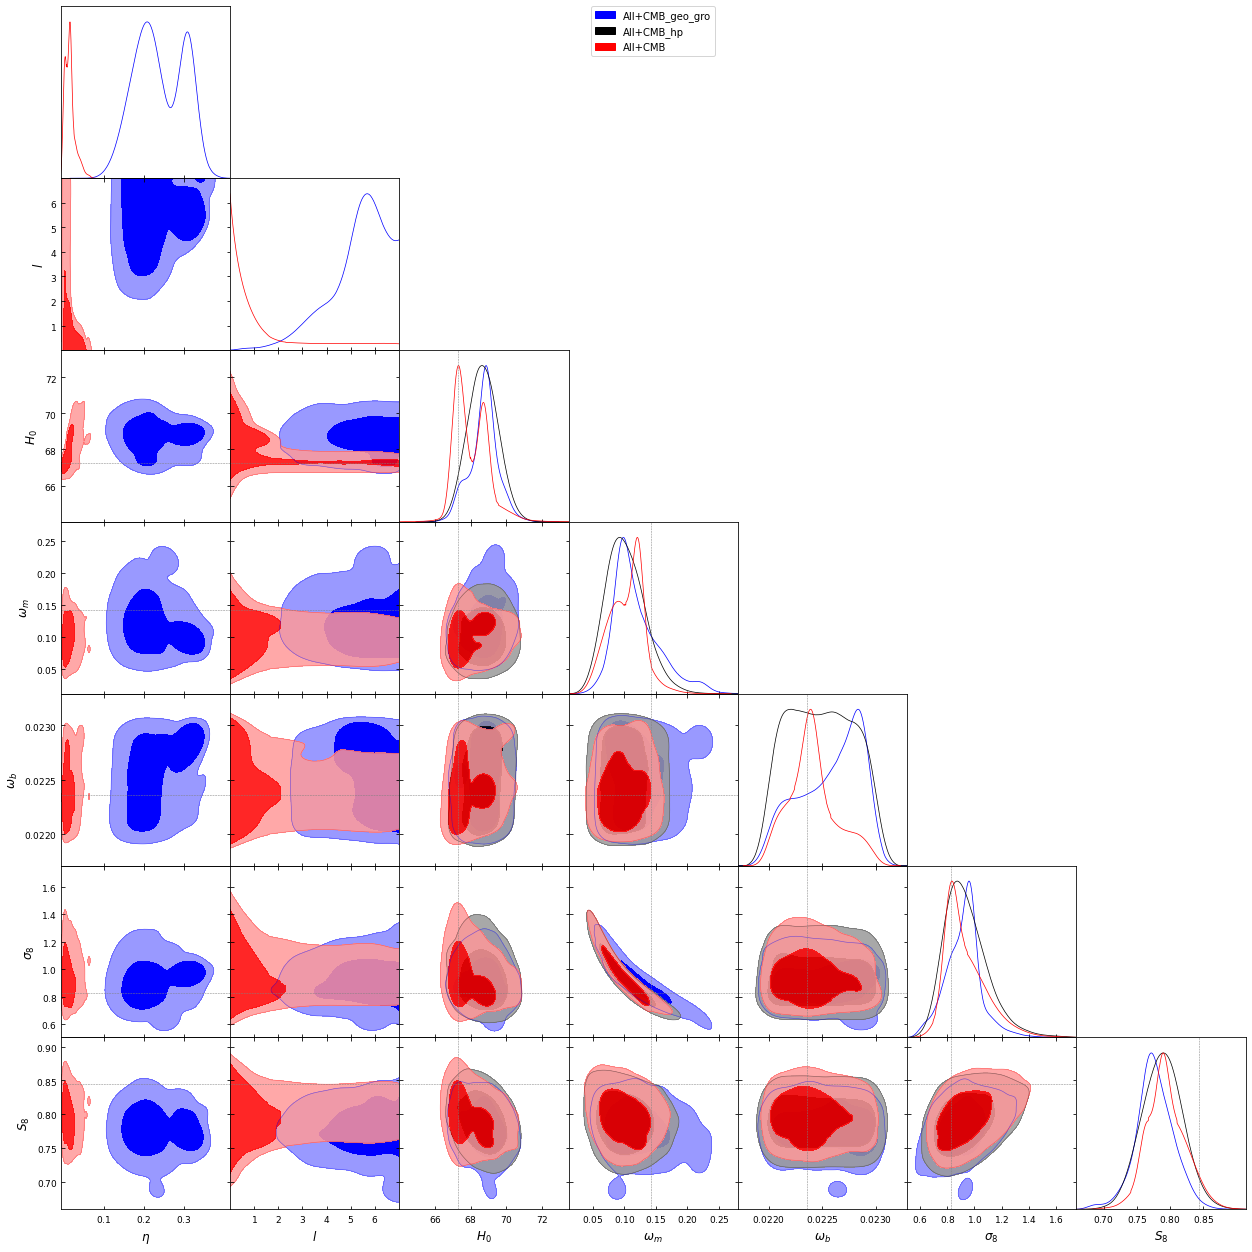

In [125]:
g = plots.getSubplotPlotter(subplot_size=2.5)
g.triangle_plot([ All_CMB_geo_gro_samples, All_CMB_hp_samples, All_CMB_samples],
                ['n', 'l', 'H0_gp', 'omega_m', 'omega_b', 's80', 'S80'],
                colors = ['blue', 'black',  'red'],
                contour_colors = ['blue', 'black', 'red'],
                filled=True,
                markers={'H0_gp':100*data_class.cosmo.h(),
                         'Omega_m': data_class.cosmo.Omega_m(),
                         'Omega_b': data_class.cosmo.Omega_b(),
                         'omega_m': data_class.cosmo.Omega_m()*data_class.cosmo.h()**2,
                         'omega_b': data_class.cosmo.Omega_b()*data_class.cosmo.h()**2,
                         'Omega_L': data_class.cosmo.Omega_Lambda(),
                         's80': data_class.cosmo.sigma8(), 
                         'S80': data_class.cosmo.sigma8()*np.sqrt(data_class.cosmo.Omega_m()/0.3)})

g.export('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/triangle_tests.pdf')

# Xi

In [126]:
dXi_All_CMB_Xi_m, dXi_All_CMB_Xi_s = get_m_s(1+All_CMB_Xi['DXiz'])
dXi_All_CMB_Xi_wm_m, dXi_All_CMB_Xi_wm_s = get_m_s(1+All_CMB_Xi_wm['DXiz'])
dXi_All_CMB_Xi_full_m, dXi_All_CMB_Xi_full_s = get_m_s(1+All_CMB_Xi_full['DXiz'])

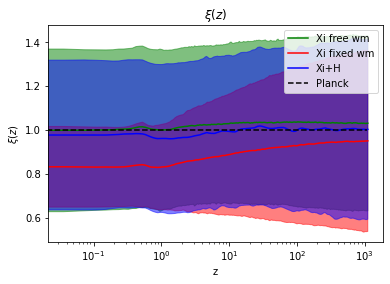

In [127]:
plt.plot(z_arr,  dXi_All_CMB_Xi_m, color ='g', label='Xi free wm')
plt.fill_between(z_arr, dXi_All_CMB_Xi_m+dXi_All_CMB_Xi_s,
                 dXi_All_CMB_Xi_m-dXi_All_CMB_Xi_s, color='g', alpha=.5)
plt.plot(z_arr,  dXi_All_CMB_Xi_wm_m, color ='r', label='Xi fixed wm')
plt.fill_between(z_arr, dXi_All_CMB_Xi_wm_m+dXi_All_CMB_Xi_wm_s,
                 dXi_All_CMB_Xi_wm_m-dXi_All_CMB_Xi_wm_s, color='r', alpha=.5)
plt.plot(z_arr,  dXi_All_CMB_Xi_full_m, color ='b', label='Xi+H')
plt.fill_between(z_arr, dXi_All_CMB_Xi_full_m+dXi_All_CMB_Xi_full_s,
                 dXi_All_CMB_Xi_full_m-dXi_All_CMB_Xi_full_s, color='b', alpha=.5)


plt.plot(z_planck, np.ones_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlabel("z")
plt.ylabel(r"$ \xi(z)$")
plt.title(r"$\xi(z)$")
plt.legend();

# d_H gp 

In [128]:
dH_DESI_CMB_m, dH_DESI_CMB_s = get_m_s(DESI_CMB['DHz'])
dH_WFIRST_CMB_m, dH_WFIRST_CMB_s = get_m_s(WFIRST_CMB['DHz'])
dH_All_m, dH_All_s = get_m_s(All['DHz'])
dH_All_CMB_m, dH_All_CMB_s = get_m_s(All_CMB['DHz'])
dH_All_CMB_hp_m, dH_All_CMB_hp_s = get_m_s(All_CMB_hp['DHz'])
dH_All_CMB_geo_gro_m, dH_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['DHz'])
dH_All_CMB_Xi_full_m, dH_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['DHz'])
dH_SDSS_m, dH_SDSS_s = get_m_s(SDSS['DHz'])
dH_SDSS_CMB_m, dH_SDSS_CMB_s = get_m_s(SDSS_CMB['DHz'])
dH_Add_m, dH_Add_s = get_m_s(Add['DHz'])
dH_Add_CMB_m, dH_Add_CMB_s = get_m_s(Add_CMB['DHz'])

Planck = data_class.Planck
z_planck = data_class.z_planck

<ipython-input-129-c3f39b62ef1c>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


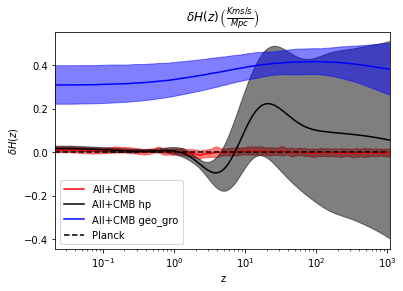

In [129]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All+CMB')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_hp_m, color ='k', label='All+CMB hp')
plt.fill_between(z_arr, dH_All_CMB_hp_m+dH_All_CMB_hp_s,
                 dH_All_CMB_hp_m-dH_All_CMB_hp_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_All_CMB_geo_gro_m, color ='b', label='All+CMB geo_gro')
plt.fill_between(z_arr, dH_All_CMB_geo_gro_m+dH_All_CMB_geo_gro_s,
                 dH_All_CMB_geo_gro_m-dH_All_CMB_geo_gro_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

<ipython-input-130-2d1024bc996d>:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


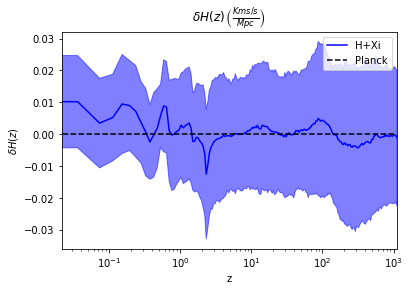

In [130]:
plt.plot(z_arr,  dH_All_CMB_Xi_full_m, color ='b', label='H+Xi ')
plt.fill_between(z_arr, dH_All_CMB_Xi_full_m+dH_All_CMB_Xi_full_s,
                 dH_All_CMB_Xi_full_m-dH_All_CMB_Xi_full_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')


plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_tests.pdf')  

<ipython-input-131-62cc4f9ab853>:10: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s,
<ipython-input-131-62cc4f9ab853>:20: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


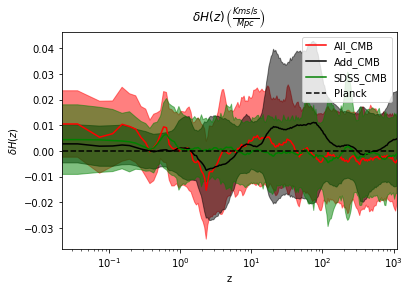

In [131]:
plt.plot(z_arr,  dH_All_CMB_m, color ='r', label='All_CMB')
plt.fill_between(z_arr, dH_All_CMB_m+dH_All_CMB_s,
                 dH_All_CMB_m-dH_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  dH_Add_CMB_m, color ='k', label='Add_CMB')
plt.fill_between(z_arr, dH_Add_CMB_m+dH_Add_CMB_s,
                 dH_Add_CMB_m-dH_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  dH_SDSS_CMB_m, color ='g', label='SDSS_CMB')
plt.fill_between(z_arr, dH_SDSS_CMB_m+dH_SDSS_CMB_s,
                 dH_SDSS_CMB_m-dH_SDSS_CMB_s, color='gk', alpha=.5)

#plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI_CMB')
#plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
#                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_data.pdf')  

<ipython-input-132-0365c2a5fad1>:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1100)


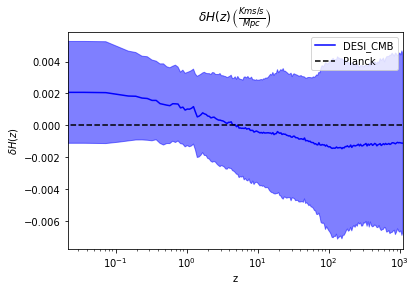

In [132]:
plt.plot(z_arr,  dH_DESI_CMB_m, color ='b', label='DESI_CMB')
plt.fill_between(z_arr, dH_DESI_CMB_m+dH_DESI_CMB_s,
                 dH_DESI_CMB_m-dH_DESI_CMB_s, color='b', alpha=.5)

#plt.plot(z_arr,  dH_WFIRST_CMB_m, color ='y', label='WFIRST_CMB')
#plt.fill_between(z_arr, dH_WFIRST_CMB_m+dH_WFIRST_CMB_s,
#                 dH_WFIRST_CMB_m-dH_WFIRST_CMB_s, color='y', alpha=.5)

plt.plot(z_planck, np.zeros_like(z_planck), 'k--', label='Planck')

plt.xscale('log')
plt.xlim(0, 1100)
plt.xlabel("z")
plt.ylabel(r"$ \delta H(z)$")
plt.title(r"$\delta H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/dH_gp_forecast.pdf')  

# H gp 

In [133]:
H_DESI_m, H_DESI_s = get_m_s(DESI['Hz'])
H_DESI_CMB_m, H_DESI_CMB_s = get_m_s(DESI_CMB['Hz'])
H_WFIRST_CMB_m, H_WFIRST_CMB_s = get_m_s(WFIRST_CMB['Hz'])
H_All_m, H_All_s = get_m_s(All['Hz'])
H_All_CMB_m, H_All_CMB_s = get_m_s(All_CMB['Hz'])
H_All_CMB_hp_m, H_All_CMB_hp_s = get_m_s(All_CMB_hp['Hz'])
H_All_CMB_full_m, H_All_CMB_full_s = get_m_s(All_CMB_full['Hz'])
H_All_CMB_geo_gro_m, H_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['Hz'])
H_All_CMB_Xi_full_m, H_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['Hz'])
H_SDSS_m, H_SDSS_s = get_m_s(SDSS['Hz'])
H_SDSS_CMB_m, H_SDSS_CMB_s = get_m_s(SDSS_CMB['Hz'])
H_Add_m, H_Add_s = get_m_s(Add['Hz'])
H_Add_CMB_m, H_Add_CMB_s = get_m_s(Add_CMB['Hz'])

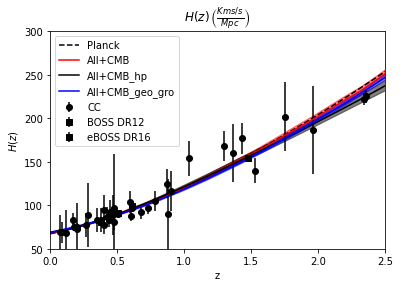

In [134]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='All+CMB')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s, H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  H_All_CMB_hp_m, color ='k', label='All+CMB_hp')
plt.fill_between(z_arr, H_All_CMB_hp_m+H_All_CMB_hp_s,
                 H_All_CMB_hp_m-H_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  H_All_CMB_geo_gro_m, color ='b', label='All+CMB_geo_gro')
plt.fill_between(z_arr, H_All_CMB_geo_gro_m+H_All_CMB_geo_gro_s,
                 H_All_CMB_geo_gro_m-H_All_CMB_geo_gro_s, color='b', alpha=.5)
#plt.plot(z_arr,  H_All_CMB_full_m, color ='g', label='All+CMB_full Data')
#plt.fill_between(z_arr, H_All_CMB_full_m+H_All_CMB_full_s,
#                 H_All_CMB_full_m-H_All_CMB_full_s, color='g', alpha=.5)


# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_tests.pdf')  

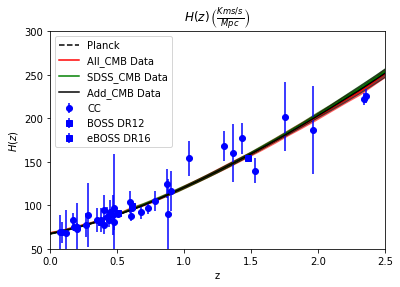

In [135]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='bo', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='bs', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_m, color ='r', label='All_CMB Data')
plt.fill_between(z_arr, H_All_CMB_m+H_All_CMB_s,
                 H_All_CMB_m-H_All_CMB_s, color='r', alpha=.5)

plt.plot(z_arr,  H_SDSS_CMB_m, color ='g', label='SDSS_CMB Data')
plt.fill_between(z_arr, H_SDSS_CMB_m+H_SDSS_CMB_s, 
                 H_SDSS_CMB_m-H_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  H_Add_CMB_m, color ='k', label='Add_CMB Data')
plt.fill_between(z_arr, H_Add_CMB_m+H_Add_CMB_s,
                 H_Add_CMB_m-H_Add_CMB_s, color='k', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

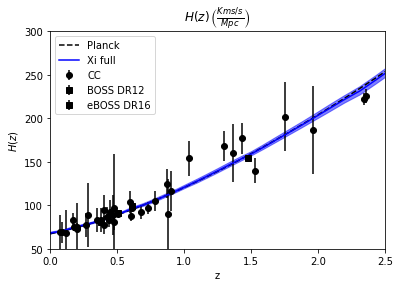

In [136]:
plt.plot(z_planck, Planck['Hkms_arr'], 'k--', label='Planck')

plt.errorbar(CC_data['z'], CC_data['data'], yerr = CC_data['err'], fmt='ko', label='CC')
plt.errorbar(BOSS_data['z'], BOSS_data['para_data'], yerr=BOSS_data['para_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], c/1000/(eBOSS_data['para_data']*eBOSS_data['rd']), 
             yerr = 1/eBOSS_data['rd']/(np.array([0.47])), fmt='ks', label='eBOSS DR16')

plt.plot(z_arr,  H_All_CMB_Xi_full_m, color ='b', label='Xi full')
plt.fill_between(z_arr, H_All_CMB_Xi_full_m+H_All_CMB_Xi_full_s,
                 H_All_CMB_Xi_full_m-H_All_CMB_Xi_full_s, color='b', alpha=.5)

# axis labels and title
plt.xlim(0, 2.5)
plt.ylim(50, 300)
plt.xlabel("z")
plt.ylabel(r"$H(z)$")
plt.title(r"$H(z) \, \left(\frac{Kms/s}{Mpc} \right)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/H_gp_data.pdf')  

# dM

In [137]:
dM_DESI_m, dM_DESI_s = get_m_s(DESI['dMz'])
dM_DESI_CMB_m, dM_DESI_CMB_s = get_m_s(DESI_CMB['dMz'])
dM_All_m, dM_All_s = get_m_s(All['dMz'])
dM_All_CMB_m, dM_All_CMB_s = get_m_s(All_CMB['dMz'])
dM_All_CMB_hp_m, dM_All_CMB_hp_s = get_m_s(All_CMB_hp['dMz'])
dM_All_CMB_full_m, dM_All_CMB_full_s = get_m_s(All_CMB_full['dMz'])
dM_All_CMB_geo_gro_m, dM_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['dMz'])
dM_All_CMB_Xi_full_m, dM_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['dMz'])
dM_SDSS_m, dM_SDSS_s = get_m_s(SDSS['dMz'])
dM_SDSS_CMB_m, dM_SDSS_CMB_s = get_m_s(SDSS_CMB['dMz'])
dM_Add_m, dM_Add_s = get_m_s(Add['dMz'])
dM_Add_CMB_m, dM_Add_CMB_s = get_m_s(Add_CMB['dMz'])

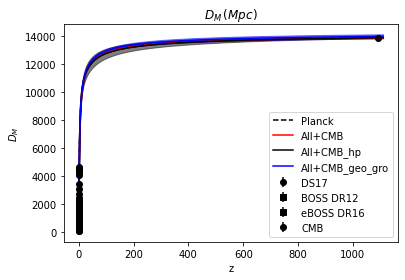

In [138]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='All+CMB')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s, dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_hp_m, color ='k', label='All+CMB_hp')
plt.fill_between(z_arr, dM_All_CMB_hp_m+dM_All_CMB_hp_s,
                 dM_All_CMB_hp_m-dM_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  dM_All_CMB_geo_gro_m, color ='b', label='All+CMB_geo_gro')
plt.fill_between(z_arr, dM_All_CMB_geo_gro_m+dM_All_CMB_geo_gro_s,
                 dM_All_CMB_geo_gro_m-dM_All_CMB_geo_gro_s, color='b', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')  

<ipython-input-139-eb0ba2389291>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(z_planck,  dM_All_CMB_m[:-1]/Planck['dM_arr'], color ='r', label='All+CMB Data')
<ipython-input-139-eb0ba2389291>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(z_planck, (dM_All_CMB_m+dM_All_CMB_s)[:-1]/Planck['dM_arr'],
<ipython-input-139-eb0ba2389291>:3: RuntimeWarning: invalid value encountered in true_divide
  (dM_All_CMB_m-dM_All_CMB_s)[:-1]/Planck['dM_arr'], color='r', alpha=.5)
<ipython-input-139-eb0ba2389291>:4: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(z_planck,  dM_All_CMB_hp_m[:-1]/Planck['dM_arr'], color ='k', label='All+CMB_hp Data')
<ipython-input-139-eb0ba2389291>:5: RuntimeWarning: invalid value encountered in true_divide
  plt.fill_between(z_planck, (dM_All_CMB_hp_m+dM_All_CMB_hp_s)[:-1]/Planck['dM_arr'],
<ipython-input-139-eb0ba2389291>:6: RuntimeWarning: invalid value encountered in true_divide
  (dM_All_CM

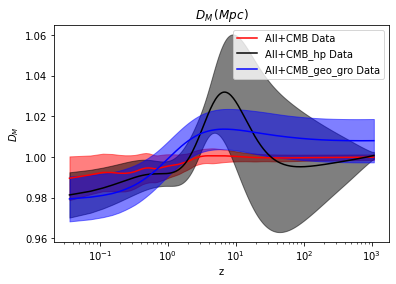

In [139]:
plt.plot(z_planck,  dM_All_CMB_m[:-1]/Planck['dM_arr'], color ='r', label='All+CMB Data')
plt.fill_between(z_planck, (dM_All_CMB_m+dM_All_CMB_s)[:-1]/Planck['dM_arr'],
                (dM_All_CMB_m-dM_All_CMB_s)[:-1]/Planck['dM_arr'], color='r', alpha=.5)
plt.plot(z_planck,  dM_All_CMB_hp_m[:-1]/Planck['dM_arr'], color ='k', label='All+CMB_hp Data')
plt.fill_between(z_planck, (dM_All_CMB_hp_m+dM_All_CMB_hp_s)[:-1]/Planck['dM_arr'],
                 (dM_All_CMB_hp_m-dM_All_CMB_hp_s)[:-1]/Planck['dM_arr'], color='k', alpha=.5)
plt.plot(z_planck,  dM_All_CMB_geo_gro_m[:-1]/Planck['dM_arr'], color ='b', label='All+CMB_geo_gro Data')
plt.fill_between(z_planck, (dM_All_CMB_geo_gro_m+dM_All_CMB_geo_gro_s)[:-1]/Planck['dM_arr'],
                 (dM_All_CMB_geo_gro_m-dM_All_CMB_geo_gro_s)[:-1]/Planck['dM_arr'], color='b', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();
plt.xscale('log')

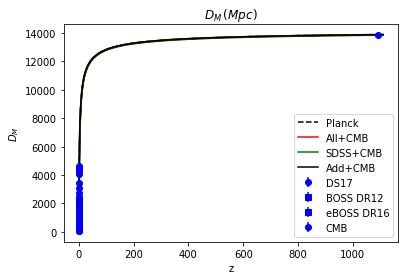

In [140]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='bo', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='bs', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='bo', label='CMB')

plt.plot(z_arr,  dM_All_CMB_m, color ='r', label='All+CMB')
plt.fill_between(z_arr, dM_All_CMB_m+dM_All_CMB_s,
                 dM_All_CMB_m-dM_All_CMB_s, color='r', alpha=.5)
plt.plot(z_arr,  dM_SDSS_CMB_m, color ='g', label='SDSS+CMB')
plt.fill_between(z_arr, dM_SDSS_CMB_m+dM_SDSS_CMB_s,
                 dM_SDSS_CMB_m-dM_SDSS_CMB_s, color='g', alpha=.5)
plt.plot(z_arr,  dM_Add_CMB_m, color ='k', label='Add+CMB')
plt.fill_between(z_arr, dM_Add_CMB_m+dM_Add_CMB_s,
                 dM_Add_CMB_m-dM_Add_CMB_s, color='k', alpha=.5)


plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_data.pdf')  

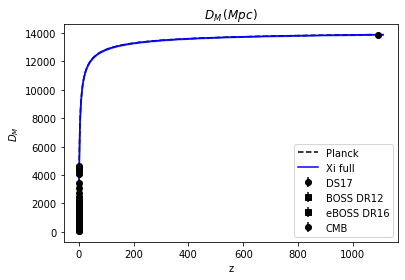

In [141]:
plt.plot(z_planck, Planck['dM_arr'], 'k--', label='Planck')

plt.errorbar(DS17_data['z'], (10**((DS17_data['data']-25+19.49)/5))/(1+DS17_data['z']),
             yerr=(10**(DS17_data['err']/5))/(1+DS17_data['z']), fmt='ko', label='DS17')
plt.errorbar(BOSS_data['z'], BOSS_data['perp_data'], yerr=BOSS_data['perp_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['perp_data']*eBOSS_data['rd'],
             yerr=np.array([0.79])*eBOSS_data['rd'], fmt='ks', label='eBOSS DR16')
plt.errorbar(CMB_data['z'], (1/CMB_data['data'])*(100*CMB_data['rd']),
             yerr=(1/CMB_data['err'])*1/(100*CMB_data['rd']), fmt='ko', label='CMB')

plt.plot(z_arr,  dM_All_CMB_Xi_full_m, color ='b', label='Xi full')
plt.fill_between(z_arr, dM_All_CMB_Xi_full_m+dM_All_CMB_Xi_full_s,
                 dM_All_CMB_Xi_full_m-dM_All_CMB_Xi_full_s, color='b', alpha=.5)

plt.xlabel("z")
plt.ylabel(r"$D_M$")
plt.title(r"$D_M \, (Mpc)$")
plt.legend();

#os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')
#plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/DM_gp_tests.pdf')  

# fs8

In [142]:
fs8_DESI_m, fs8_DESI_s = get_m_s(DESI['fs8z'])
fs8_DESI_CMB_m, fs8_DESI_CMB_s = get_m_s(DESI_CMB['fs8z'])
fs8_All_m, fs8_All_s = get_m_s(All['fs8z'])
fs8_All_CMB_m, fs8_All_CMB_s = get_m_s(All_CMB['fs8z'])
fs8_All_CMB_full_m, fs8_All_CMB_full_s = get_m_s(All_CMB_full['fs8z'])
fs8_All_CMB_geo_gro_m, fs8_All_CMB_geo_gro_s = get_m_s(All_CMB_geo_gro['fs8z'])
fs8_All_CMB_hp_m, fs8_All_CMB_hp_s = get_m_s(All_CMB_hp['fs8z'])
fs8_All_CMB_Xi_m, fs8_All_CMB_Xi_s = get_m_s(All_CMB_Xi['fs8z'])
fs8_All_CMB_Xi_wm_m, fs8_All_CMB_Xi_wm_s = get_m_s(All_CMB_Xi_wm['fs8z'])
fs8_All_CMB_Xi_full_m, fs8_All_CMB_Xi_full_s = get_m_s(All_CMB_Xi_full['fs8z'])
fs8_SDSS_m, fs8_SDSS_s = get_m_s(SDSS['fs8z'])
fs8_SDSS_CMB_m, fs8_SDSS_CMB_s = get_m_s(SDSS_CMB['fs8z'])
fs8_Add_m, fs8_Add_s = get_m_s(Add['fs8z'])
fs8_Add_CMB_m, fs8_Add_CMB_s = get_m_s(Add_CMB['fs8z'])

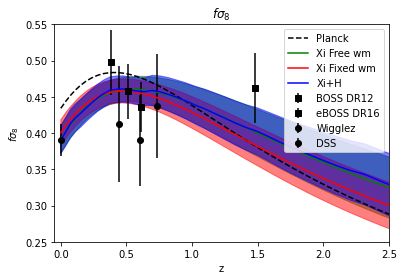

In [143]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')

plt.plot(z_arr,  fs8_All_CMB_Xi_m, color ='g', label='Xi Free wm')
plt.fill_between(z_arr, fs8_All_CMB_Xi_m+fs8_All_CMB_Xi_s,
                 fs8_All_CMB_Xi_m-fs8_All_CMB_Xi_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_Xi_wm_m, color ='r', label='Xi Fixed wm')
plt.fill_between(z_arr, fs8_All_CMB_Xi_wm_m+fs8_All_CMB_Xi_wm_s,
                 fs8_All_CMB_Xi_wm_m-fs8_All_CMB_Xi_wm_s, color='r', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_Xi_full_m, color ='b', label='Xi+H')
plt.fill_between(z_arr, fs8_All_CMB_Xi_full_m+fs8_All_CMB_Xi_full_s,
                 fs8_All_CMB_Xi_full_m-fs8_All_CMB_Xi_full_s, color='b', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

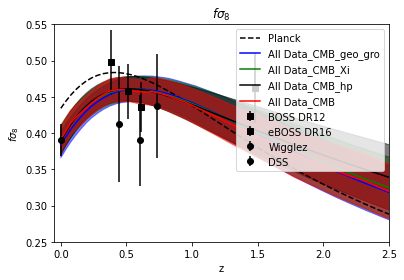

In [144]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='ks', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='ks', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='ko', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='ko', label='DSS')


plt.plot(z_arr,  fs8_All_CMB_geo_gro_m, color ='b', label='All Data_CMB_geo_gro')
plt.fill_between(z_arr, fs8_All_CMB_geo_gro_m+fs8_All_CMB_geo_gro_s,
                 fs8_All_CMB_geo_gro_m-fs8_All_CMB_geo_gro_s, color='b', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_Xi_m, color ='g', label='All Data_CMB_Xi')
plt.fill_between(z_arr, fs8_All_CMB_Xi_m+fs8_All_CMB_Xi_s,
                 fs8_All_CMB_Xi_m-fs8_All_CMB_Xi_s, color='g', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_hp_m, color ='k', label='All Data_CMB_hp')
plt.fill_between(z_arr, fs8_All_CMB_hp_m+fs8_All_CMB_hp_s,
                 fs8_All_CMB_hp_m-fs8_All_CMB_hp_s, color='k', alpha=.5)
plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All Data_CMB')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)


plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_tests.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_tests.pdf')  

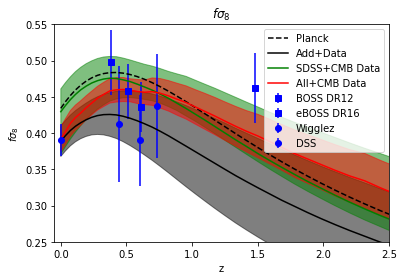

In [145]:
plt.plot(z_planck, Planck['fs8_arr'], 'k--', label='Planck')
plt.errorbar(BOSS_data['z'], BOSS_data['fs8_data'], yerr=BOSS_data['fs8_err'], fmt='bs', label='BOSS DR12')
plt.errorbar(eBOSS_data['z'], eBOSS_data['fs8_data'], yerr=eBOSS_data['fs8_err'], fmt='bs', label='eBOSS DR16')
plt.errorbar(Wigglez_data['z'], Wigglez_data['data'], yerr=Wigglez_data['err'], fmt='bo', label='Wigglez')
plt.errorbar(DSS_data['z'], DSS_data['data'], yerr=DSS_data['err'], fmt='bo', label='DSS')

plt.plot(z_arr,  fs8_Add_CMB_m, color ='k', label='Add+Data')
plt.fill_between(z_arr, fs8_Add_CMB_m+fs8_Add_CMB_s,
                 fs8_Add_CMB_m-fs8_Add_CMB_s, color='k', alpha=.5)

plt.plot(z_arr,  fs8_SDSS_m, color ='g', label='SDSS+CMB Data')
plt.fill_between(z_arr, fs8_SDSS_CMB_m+fs8_SDSS_CMB_s,
                 fs8_SDSS_CMB_m-fs8_SDSS_CMB_s, color='g', alpha=.5)

plt.plot(z_arr,  fs8_All_CMB_m, color ='r', label='All+CMB Data')
plt.fill_between(z_arr, fs8_All_CMB_m+fs8_All_CMB_s,
                 fs8_All_CMB_m-fs8_All_CMB_s, color='r', alpha=.5)

plt.xlim(-0.05, 2.5)
plt.ylim(0.25, 0.55)
plt.xlabel("z")
plt.ylabel(r"$f \sigma_8$")
plt.title(r"$f \sigma_8$")
plt.legend();

os.remove('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')
plt.savefig('/mnt/c/Users/Jaime/Desktop/PhD/gp_figures/fs8_gp_data.pdf')  